In [1]:
import pandas as pd

placements: pd.DataFrame = pd.read_pickle('fragmenstein_placed_iter3.pkl.gz')

In [2]:
placements.loc[placements.outcome == 'acceptable'].sort_values('∆∆G')[['name', '∆∆G']]

,name,∆∆G
860,Z3575577435-x2149-0AS6-D68EV3CPROA-x1140-0AS5,-11.610017
13097,Z4267525845-x1919-0AS10-D68EV3CPROA-x0771-0AS1,-11.524712
13114,Z3408515872-x1919-0AS10-D68EV3CPROA-x0771-0AS1,-11.325891
13112,Z3470308873-x1919-0AS10-D68EV3CPROA-x0771-0AS1,-11.226745
1774,Z4264833334-x1919-0AS6-D68EV3CPROA-x1140-0AS2,-11.197881
...,...,...
2636,Z1536895087-x1919-0AS4-D68EV3CPROA-x0789-0AS4,-1.027488
1814,PV-002419855833-x1084-0A-D68EV3CPROA-x1604-0AS2,-1.023931
5699,Z3338736816-x1919-0AS4-D68EV3CPROA-x0789-0AS2,-1.017407
15096,Z3308354354-x1329-0AS1-D68EV3CPROA-x1305-0B,-1.006333


In [4]:
from fragmenstein_merge_sw_place import score, DEFAULT_WEIGHTS

/Users/user/.conda/envs/py310/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
PyRosetta-4 2023 [Rosetta PyRosetta4.Release.python310.m1 2023.16+release.942c01d5066fd96860b7d268702b832fe906a739 2023-04-12T15:05:51] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [5]:
hit_replacements = pd.read_pickle('fragmenstein_hit_replacements_iter3.pkl.gz')

In [6]:
import operator
hits = [m for m in hit_replacements.hit_mols.apply(operator.itemgetter(0))]

In [7]:
score(placements, hit_replacements,
      suffix='_iter3', hits=hits, weights=DEFAULT_WEIGHTS
     )
placements.to_pickle(f'fragmenstein_placed_iter3.fixed.pkl.gz')

/Users/user/Coding/EV-D68-3C-protease-v1.1/fragmenstein_merge_sw_place.py:303: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hit_replacements['new_name'] = hit_replacements.hit_mols.apply(lambda ms: ms[0].GetProp('_Name'))


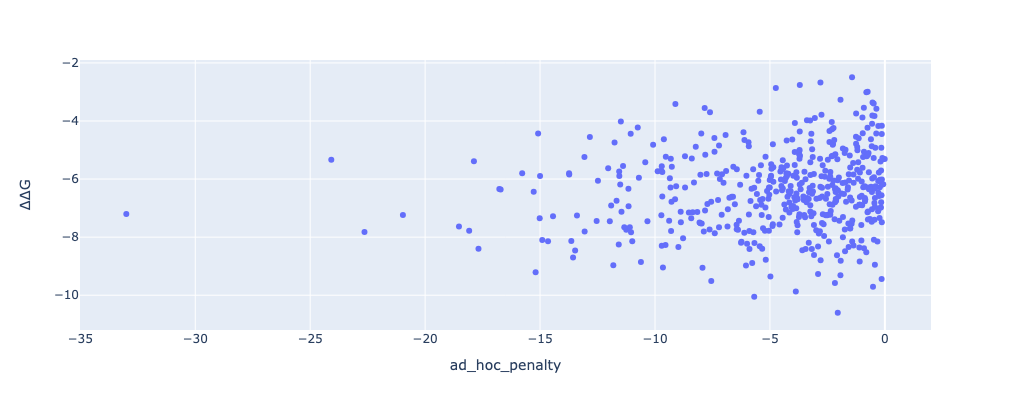

In [12]:
import plotly.express as px

px.scatter(placements.loc[placements.ad_hoc_penalty < 0], 'ad_hoc_penalty', '∆∆G')

In [36]:
weights=DEFAULT_WEIGHTS
weights['∆∆G'] = 5
weights['N_constrained_atoms'] = -0.5
weights['N_unconstrained_atoms'] = 0.25
weights

{'N_rotatable_bonds': 3,
 '∆∆G': 5,
 'interaction_uniqueness_metric': -20,
 'N_unconstrained_atoms': 0.25,
 'N_constrained_atoms': -0.5,
 'N_interactions': -5,
 'N_interactions_lost': 10,
 'max_hit_Tanimoto': -1,
 'N_PAINS': 20,
 'strain_per_HA': 1}

In [37]:
from fragmenstein_merge_sw_place import PenaltyMeter
penalize = PenaltyMeter(weights)
placements['ad_hoc_penalty'] = placements.apply(penalize, axis=1)
placements['ranked'] = placements.ad_hoc_penalty.rank(method='min')

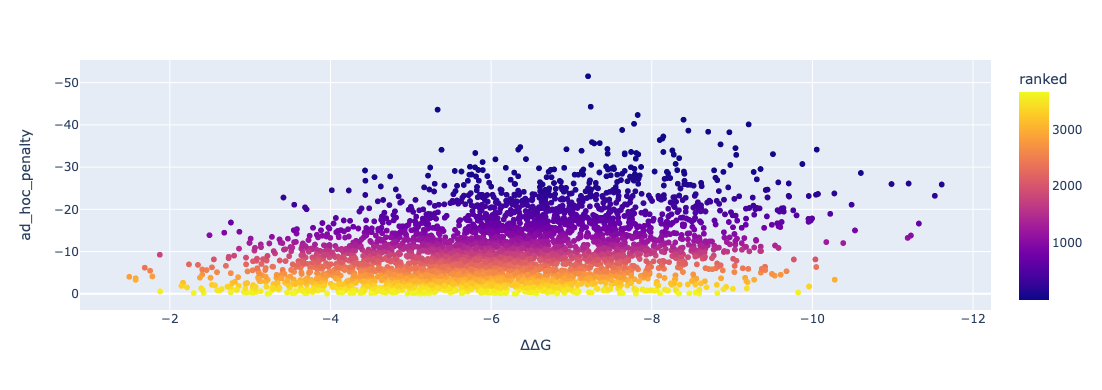

In [38]:
import plotly.express as px

fig = px.scatter(placements.loc[placements.ad_hoc_penalty < 0],
                 x='∆∆G', y='ad_hoc_penalty',
                color='ranked',
                )
fig.update_layout(xaxis = dict(autorange = "reversed"),
                  yaxis = dict(autorange = "reversed"))

In [41]:
from collections import defaultdict

tally = defaultdict(int)
def assign_rank(row):
    k = ','.join(row.hit_names)
    tally[k] += 1
    return tally[k]

placements['merger_rank'] = placements.sort_values('ad_hoc_penalty').drop_duplicates('cluster').apply(assign_rank, axis=1)
placements['merger_rank'] = placements['merger_rank'].fillna(999).astype(int)

In [67]:
method_name = 'Fragmenstein-Tris'
target_name='D68EV3CPROA'
top_n = 200

from rdkit import Chem
from typing import List
from gist_import import GistImporter

fmodule = GistImporter.from_github('https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/followup/prep_fragalysis.py')
prep = fmodule['prep']
generate_header = fmodule['generate_header']


def fix(mol: Chem.Mol):
    assert isinstance(mol, Chem.Mol)
    assert mol.GetNumAtoms()
    mol.ClearComputedProps()
    for name in mol.GetPropNames():
        mol.ClearProp(name)

with pd.option_context('mode.chained_assignment', None):

    df = placements.loc[placements.outcome == 'acceptable']\
                   .sort_values('ad_hoc_penalty')\
                   .rename(columns={c: ':'.join(map(str, c)) for c in placements.columns if isinstance(c, tuple)})\
                   .head(top_n) \
                   .reset_index()
    df = df.loc[df.merger_rank < 5].copy()
    # list of str to str w/ comma-separator
    df['ref_mols'] = df.hit_names.apply(lambda l: ','.join([v.replace(f'{target_name}-', '') for v in l]))
    df['washed_mol'] = df.minimized_mol.apply(fix)
    df['name'] = df['name'].apply(lambda v: v.split('-D68EV3CPROA')[0])
    # non str/float/ints
    not_okay = ('name', 'minimized_mol', 'ref_mols', 'washed_mol', 'mode',
                'runtime','error','outcome',
                'smiles',
                 'regarded', 'disregarded', 'hit_names',
                  '∆G_bound',
                 '∆G_unbound',
                 'unmin_binary',
                 'min_binary',
                'binary_hits', 'custom_map', 'PAINSes',
                 'hit_binaries',
                'minimized_mol',
                  'hit_mols','unminimized_mol', 'hit_names')
nonempty = [c for c, v in (df[[c for c in df.columns if ':' in c]].sum() > 0).to_dict().items() if v]
extras: List[str] = [c for c in df.columns if c not in not_okay and ':' not in c] + nonempty
def floatify(value):
    try:
        return float(value)
    except Exception:
        return float('nan')

bad_columns = [k for k in extras if df[k].apply(floatify).isna().any()]
assert not bad_columns, f'Some entries are not numeric {bad_columns}'
header: Chem.Mol = generate_header(method_name,
                         ref_url='https://github.com/matteoferla/Fragment-hit-follow-up-chemistry',
                         submitter_name='Matteo Ferla',
                         submitter_email='matteo.ferla@stats.ox.ac.uk',
                         extras=dict(zip(extras, extras))
                        )
prep(df, header, mol_col='minimized_mol', name_col='name', outfile=f'{method_name}.sdf', ref_pdb='x0147_0A',
     extras=extras
    )

[17:51:47] Molecule does not have explicit Hs. Consider calling AddHs()


In [69]:
df

,index,smiles,name,binary_hits,custom_map,error,mode,∆∆G,∆G_bound,∆G_unbound,...,UFF_Gibbs,strain_per_HA,ad_hoc_penalty,cluster,ranked,merger_rank,ref_mols,washed_mol,original SMILES,ref_pdb
0,17550,CC1=CC(C(=O)NCC(C)(C)C)=NO1,Z814868448-x1071-0AS5,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x1071_0AS5': {0: 8, 1: 10, 2: 11, 3: 9}, 'D6...",,expansion,-7.207084,-7.304035,-0.096951,...,133.266841,9.518992,-51.514120,319,1.0,1,"x1071_0AS5,x1052_1AS2",None,[H]c1c(C(=O)N([H])C([H])([H])C(C([H])([H])[H])...,x0147_0A
1,2229,COC(=O)NC1=CC=CC(C(=O)NC2CCN(C(=O)CCC(C)(C)C)C...,PV-004271221850-x1071-0A,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x1071_0A': {0: 20, 1: 22, 2: 24, 3: 19, 4: 1...",,expansion,-7.239933,-6.230572,1.009361,...,269.046612,9.608773,-44.296524,437,2.0,1,"x1071_0A,x1020_0A",None,[H]c1c([H])c(C(=O)N([H])C2([H])C([H])([H])C([H...,x0147_0A
2,2216,CC(=O)NC1=CC(C(=O)NC2CCN(C(=O)CCC(C)(C)F)CC2)=...,PV-005890491569-x1071-0A,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x1071_0A': {0: 17, 1: 19, 2: 21, 3: 16, 4: 1...",,expansion,-5.333765,-3.802473,1.531292,...,219.416722,7.836284,-43.599966,943,3.0,2,"x1071_0A,x1020_0A",None,[H]c1c([H])c(C(=O)N([H])C2([H])C([H])([H])C([H...,x0147_0A
3,5381,CC(=O)NNC(=O)C1=COC(C)=C1,Z1763400558-x1071-0AS2,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x1071_0AS2': {0: 5, 1: 4, 2: 6, 3: 3, 4: 1, ...",,expansion,-7.824870,-7.579182,0.245688,...,58.762771,4.520178,-42.337634,6111,4.0,1,"x1071_0AS2,x1052_1AS3",None,[H]c1oc(C([H])([H])[H])c([H])c1C(=O)N([H])N([H...,x0147_0A
4,1246,CC(=O)NCC(NC(=O)CC1=CNC(=O)C=C1)C2CCCCC2,PV-001573842640-x1071-0A,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x1071_0A': {0: 3, 1: 0, 2: -1, 3: 4, 4: 5, 5...",,expansion,-8.395819,-6.368136,2.027683,...,144.797190,6.295503,-41.220628,1597,5.0,1,"x1071_0A,x1498_0A",None,[H]c1c(C([H])([H])C(=O)N([H])C([H])(C([H])([H]...,x0147_0A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,10130,CC1=CC(NC(=O)CNC2(C)CCOC2=O)=NO1,Z2170211741-x2149-0AS2,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x2149_0AS2': {0: 10, 1: 9, 2: 11, 3: 14, 4: ...",,expansion,-5.290073,-4.499219,0.790854,...,250.648345,13.924831,-24.229499,4907,195.0,2,"x2149_0AS2,x1052_1AS2",None,[H]c1c(N([H])C(=O)C([H])([H])N([H])C2(C([H])([...,x0147_0A
195,16771,CC(=O)C1=CC=C(OCC2=CC=C3CCCC3=C2)C=C1,Z1211401012-x0771-1AS1,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x0771_1AS1': {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, ...",,expansion,-7.581412,-7.595894,-0.014482,...,176.738762,8.836894,-24.198477,1027,196.0,4,"x0771_1AS1,x1140_0AS2",None,[H]c1c([H])c(C(=O)C([H])([H])[H])c([H])c([H])c...,x0147_0A
197,1034,CN1C(=O)CCC1CNC(=O)NCC2=CC=C3OCCC3=C2,Z3777535315-x2149-0AS6,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x2149_0AS6': {0: 0, 1: -1, 2: 1, 3: 6, 4: 2,...",,expansion,-6.904847,-6.443301,0.461547,...,154.039021,7.001742,-24.152781,7094,198.0,3,"x2149_0AS6,x1140_0A",None,[H]c1c([H])c(C([H])([H])N([H])C(=O)N([H])C([H]...,x0147_0A
198,1581,CCC1=CC=C(CC(=O)NCCC2=CC=CN=C2)C=C1,Z1260734436-x1084-0A,[b'\xef\xbe\xad\xde\x00\x00\x00\x00\r\x00\x00\...,"{'x1084_0A': {0: 6, 1: -1, 2: 9, 3: 5, 4: 4, 5...",,expansion,-6.407054,-5.987882,0.419172,...,136.872007,6.843566,-24.139132,2722,199.0,4,"x1084_0A,x0980_0BS5",None,[H]c1nc([H])c(C([H])([H])C([H])([H])N([H])C(=O...,x0147_0A


In [ ]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(placements.loc[placements.name.str.contains('x2149') & (placements.outcome == 'acceptable')].smiles.apply(Chem.MolFromSmiles).to_list())

In [90]:
site1 = (161, 142)
site2 = (164, 162)

site1_intxns = [k for k in placements.columns if isinstance(k, tuple) and k[2] in site1 and k[0] != 'hydroph_interaction']
site2_intxns = [k for k in placements.columns if isinstance(k, tuple) and k[2] in site2 and k[0] != 'hydroph_interaction']
site1_map = placements[site1_intxns].sum(axis=1).astype(bool)
site2_map = placements[site2_intxns].sum(axis=1).astype(bool)

subbed = placements.loc[site1_map & site2_map & (placements.outcome == 'acceptable')].sort_values('ad_hoc_penalty')


method_name = 'Fragmenstein-Tris_P1-ridge'
target_name='D68EV3CPROA'
top_n = 200

from rdkit import Chem
from typing import List
from gist_import import GistImporter

fmodule = GistImporter.from_github('https://raw.githubusercontent.com/matteoferla/Fragment-hit-follow-up-chemistry/main/followup/prep_fragalysis.py')
prep = fmodule['prep']
generate_header = fmodule['generate_header']


def fix(mol: Chem.Mol):
    assert isinstance(mol, Chem.Mol)
    assert mol.GetNumAtoms()
    mol.ClearComputedProps()
    for name in mol.GetPropNames():
        mol.ClearProp(name)

with pd.option_context('mode.chained_assignment', None):

    df = subbed\
                   .sort_values('ad_hoc_penalty')\
                   .rename(columns={c: ':'.join(map(str, c)) for c in placements.columns if isinstance(c, tuple)})\
                   .head(top_n) \
                   .reset_index()
    df = df.loc[df.merger_rank < 5].copy()
    # list of str to str w/ comma-separator
    df['ref_mols'] = df.hit_names.apply(lambda l: ','.join([v.replace(f'{target_name}-', '') for v in l]))
    df['washed_mol'] = df.minimized_mol.apply(fix)
    df['name'] = df['name'].apply(lambda v: v.split('-D68EV3CPROA')[0])
    # non str/float/ints
    not_okay = ('name', 'minimized_mol', 'ref_mols', 'washed_mol', 'mode',
                'runtime','error','outcome',
                'smiles',
                 'regarded', 'disregarded', 'hit_names',
                  '∆G_bound',
                 '∆G_unbound',
                 'unmin_binary',
                 'min_binary',
                'binary_hits', 'custom_map', 'PAINSes',
                 'hit_binaries',
                'minimized_mol',
                  'hit_mols','unminimized_mol', 'hit_names')
nonempty = [c for c, v in (df[[c for c in df.columns if ':' in c]].sum() > 0).to_dict().items() if v]
extras: List[str] = [c for c in df.columns if c not in not_okay and ':' not in c] + nonempty
def floatify(value):
    try:
        return float(value)
    except Exception:
        return float('nan')

bad_columns = [k for k in extras if df[k].apply(floatify).isna().any()]
assert not bad_columns, f'Some entries are not numeric {bad_columns}'
header: Chem.Mol = generate_header(method_name,
                         ref_url='https://github.com/matteoferla/Fragment-hit-follow-up-chemistry',
                         submitter_name='Matteo Ferla',
                         submitter_email='matteo.ferla@stats.ox.ac.uk',
                         extras=dict(zip(extras, extras))
                        )
prep(df, header, mol_col='minimized_mol', name_col='name', outfile=f'{method_name}.sdf', ref_pdb='x0147_0A',
     extras=extras
    )

[10:07:55] Molecule does not have explicit Hs. Consider calling AddHs()
